### Architecting Analytic Pipelines on GCP - Chicago Cloud Conference 2020

In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import pandas as pd

In [2]:
!export GOOGLE_APPLICATION_CREDENTIALS='/ccc-2020-289323-1245db651f9b.json'
!pip install

Now that the data is in bigquery we can save a section to cloud storage or grab it direct from bigquery.

In [22]:
df = pd.read_csv('gs://chicago-cloud-conference-2020/nlpstorage/results-20200920-131208.csv')
df.head()

In [5]:
print(df['user_text'][0])
print(len(df['user_text']))

Así es un buen tiro en cualquier colonia de la CDMX, perros, hombres, viejas montoneras, Y DESDE LUEGO, LA PINCHE GENTE CHISMOSA. 😂😂😂😂 https://t.co/M2cpilDZqm
650


In [24]:
tweets=df[df['user_text'].str.contains('trump', na=False)]
print(len(tweets))

Retweets  0
#CDMX 148


In [25]:
from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types
from google.oauth2 import service_account
from google.protobuf.json_format import MessageToDict


score=[]
magnitude=[]
creds = service_account.Credentials.from_service_account_file('/ccc-2020-289323-1245db651f9b.json')
client = language.LanguageServiceClient(credentials=creds)

for tweet in tweets['user_text']:
    document = types.Document(
    content=tweet,
    type=enums.Document.Type.PLAIN_TEXT
    )
    analyze_sentiment_response = client.analyze_sentiment(document=document)
    message = MessageToDict(analyze_sentiment_response, including_default_value_fields=True)
    score.append(message['documentSentiment']['score'])
    magnitude.append(message['documentSentiment']['magnitude'])

print(len(score))
# print('POLARITY=%s MAGNITUDE=%s for %s' % (score, magnitude, tweet))

148


In [26]:
tweets['score']=score
tweets['magnitude']=magnitude
tweets.head()

/Users/admin/development/gov-cdmx-twitter-sentiment/streaming/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/admin/development/gov-cdmx-twitter-sentiment/streaming/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,tweet_timestamp,user_text,user_screen_nam,user_location,user_followers_count,score,magnitude
4,1597703587,RT @xime2222: Feliz lunes mis bebes😘😘 ya dispo...,Alberto71676983,NaN,18,0.4,0.4
7,1597703587,El nuevo aeropuerto de la #CDMX iba a costar 3...,serguerote,Cdmx,38,0.0,0.0
11,1597703587,Hola mis amores ya disponible😈😈💦💦 #tuflaquitac...,Alberto71676983,NaN,18,0.6,0.6
14,1597703587,"Sigue #EnAdopción #21, 2 a 3 años aprox Esteri...",reyescarmelita,"coyoacán, df",319,0.0,0.0
18,1597703587,El nuevo aeropuerto de la #CDMX iba a costar 3...,Benchito2000,"Puebla, México",569,0.0,0.0


In [27]:
tweets['datef']=pd.to_datetime(tweets['tweet_timestamp'], unit='s', yearfirst='TRUE')
tweets['datef'].head()

/Users/admin/development/gov-cdmx-twitter-sentiment/streaming/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


4    2020-08-17 22:33:07
7    2020-08-17 22:33:07
11   2020-08-17 22:33:07
14   2020-08-17 22:33:07
18   2020-08-17 22:33:07
Name: datef, dtype: datetime64[ns]

In [28]:
#averages
score_avg=np.mean(tweets['score'])
magnitude_evg=np.mean(tweets['magnitude'])
print('score', score_avg, 'magnitude', magnitude_evg)

score 0.15878378378378377 magnitude 0.47094594594594597


Text(0, 0.5, 'Magnitude')

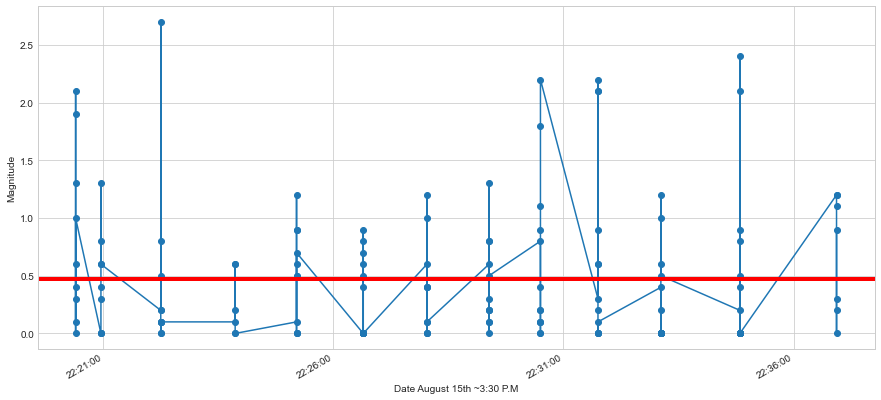

In [36]:
data = pd.concat([tweets['datef'], tweets['magnitude']], axis=1)
data.set_index('datef',inplace=True)
fig, ax = plt.subplots(figsize=(15,7))
data.plot(ax=ax, legend=False, marker='o')
ax.axhline(y=magnitude_evg, linewidth=4, color='r')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.set_xlabel('Date August 15th ~3:30 P.M')
ax.set_ylabel('Magnitude')

Text(0, 0.5, 'Score')

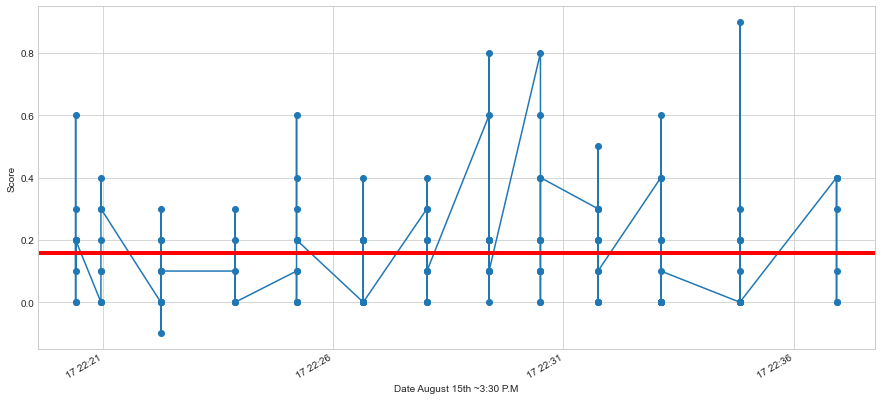

In [37]:
data2 = pd.concat([tweets['datef'], tweets['score']], axis=1)
data2.set_index('datef',inplace=True)
fig, ax2 = plt.subplots(figsize=(15,7))
data2.plot(ax=ax2, legend=False, marker='o')
ax2.axhline(y=score_avg, linewidth=4, color='r')
ax2.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax2.set_xlabel('Date August 15th ~3:30 P.M')
ax2.set_ylabel('Score')

High magnitude tweets are more impactful than low magnitude tweets, a weak statement doesn't say much.
We will concentrate only on statements with a magnitude of 0.5 or higher.

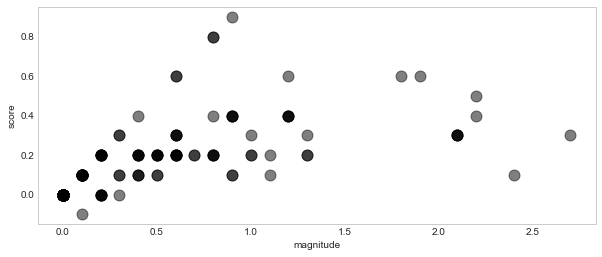

In [32]:
fig, ax = plt.subplots()
ax.figure.set_size_inches(10,4)
ax.grid(False)
ax.scatter(tweets.magnitude, tweets.score, s=120, c='black', alpha=0.5)
ax.set(xlabel='magnitude', ylabel='score')
plt.show()

We can also see that things around zero polarity (neither very positive nor negative) are not interesting to flag 

In [33]:
love=tweets[(tweets['magnitude'] >=0.5) & (tweets['score'] >=0.5)]
hate=tweets[(tweets['magnitude'] >=0.5) & (tweets['score'] <= -0.5)]

In [34]:
print(len(tweets['magnitude']), len(love['magnitude']), len(hate['magnitude']))
print("weak", len(tweets['magnitude']) - (len(love['magnitude'])+len(hate['magnitude'])))

148 9 0
weak 139


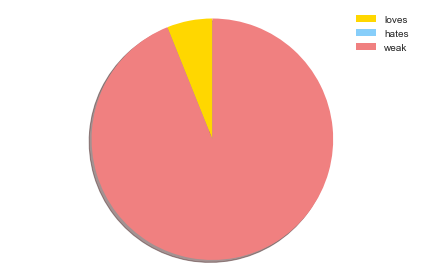

In [16]:
labels = ['loves', 'hates', 'weak']
sizes = [9, 0, 139]
colors = ['gold', 'lightskyblue', 'lightcoral']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

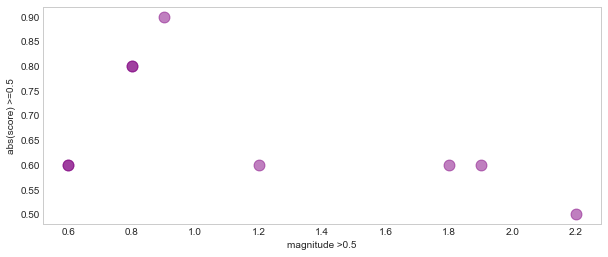

In [17]:
fig, ax= plt.subplots()
ax.scatter(love.magnitude, love.score, s=120, c='purple', alpha=0.5)
ax.scatter(hate.magnitude, hate.score, s=120, c='red', alpha=0.5)
ax.figure.set_size_inches(10,4)
ax.grid(False) 
ax.set(xlabel='magnitude >0.5', ylabel='abs(score) >=0.5')
plt.show()

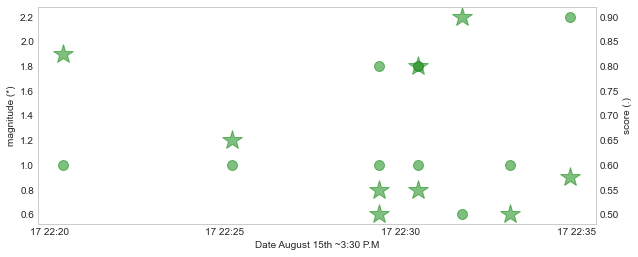

In [35]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Date August 15th ~3:30 P.M')
ax1.set_ylabel('magnitude (*)')
ax1.grid(False)
ax1.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%M'))
ax1.figure.set_size_inches(10,4)
ax1.plot(love['datef'], love['magnitude'], 'g*', markersize=20, alpha=0.5)
ax1.plot(hate['datef'], hate['magnitude'], 'r*', markersize=20, alpha=0.5)
ax2=ax1.twinx()
ax2.grid(False)
ax2.plot(love.datef, love.score, 'g.', markersize=20, alpha=0.5)
ax2.plot(hate.datef, hate.score, 'r.', markersize=20, alpha=0.5)
ax2.set_ylabel('score (.)')
plt.show()

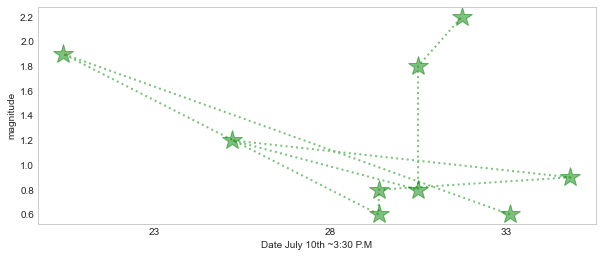

In [20]:
fig, ax = plt.subplots()
ax.set_xlabel('Date July 10th ~3:30 P.M')
ax.grid(False)
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M'))
ax.figure.set_size_inches(10,4)
ax.plot(love['datef'], love['magnitude'], 'g', linestyle=':', marker='*', linewidth=2, markersize=20, alpha=0.5)
ax.plot(hate['datef'], hate['magnitude'], 'k', linestyle=':', marker='.', linewidth=2, markersize=20, alpha=0.5)
ax.set_ylabel('magnitude')
plt.show()

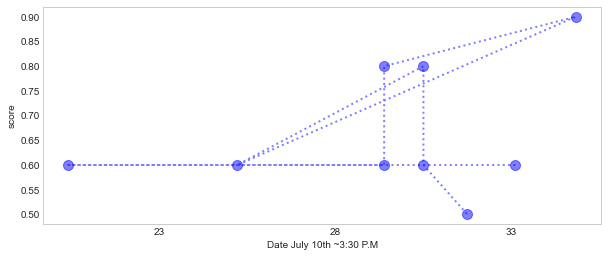

In [21]:
fig, ax = plt.subplots()
ax.set_xlabel('Date July 10th ~3:30 P.M')
ax.set_ylabel('score')
ax.grid(False)
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M'))
ax.figure.set_size_inches(10,4)
ax.plot(love['datef'], love['score'], 'b', linestyle=':', marker='.', linewidth=2, markersize=20, alpha=0.5)
ax.plot(hate['datef'], hate['score'], 'r', linestyle=':', marker='.', linewidth=2, markersize=20, alpha=0.5)
plt.show()